In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk
from joblib import Parallel, delayed
import mne 
import os

In [5]:
files = pd.read_csv('/media/davi/6A81-05CF/CHBMIT/files.txt', names=['name'])

# Edf's que tenham crises
files = files[
    files['name'].isin(['chb04_08.edf','chb04_28.edf'])
    ].to_numpy().T[0]


In [6]:
# Intervalos arbitrários de crises
fs = 256

inter = [
    {
        "Name": "chb04_08.edf",
        "Intervals": [
            {
                "Start": 6446, 
                "End": 6557
            }
        ]
    },{
        "Name": "chb04_28.edf", 
        "Intervals" : [
            {
                "Start": 1679, 
                "End": 1781
            },{
                "Start": 3782,
                "End": 3898
            }
        ]
    }
]



In [9]:
def load_edf(path):
    path_folder = '/media/davi/6A81-05CF/CHBMIT/'
    # file = path.replace('tse', 'edf')
    data = mne.io.read_raw_edf(path_folder + path)
    info = data.info
    return {"info": info, "data": data}

def raw2df(raw, file, info):
    df_ =  raw.to_data_frame()
    # return set_labels(df_, file, info)
    return df_


In [10]:
edfs = Parallel(n_jobs=-1) \
        (delayed(load_edf) \
        (item) for item in files)

ecgs = [edf['data'].to_data_frame()['ECG'] for edf in edfs]

Extracting EDF parameters from /media/davi/6A81-05CF/CHBMIT/chb04_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /media/davi/6A81-05CF/CHBMIT/chb04_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_10832/1372432966.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
/tmp/ipykernel_10832/1372432966.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.


In [12]:
# Concatenando intervalos

In [11]:
signals = []

for ecg,item in zip(ecgs,inter):
    for i in item["Intervals"]:
        signals.append(ecg.iloc[i['Start']*fs:i['End']*fs])
    

In [51]:

def pipeline(ecg):
    ecg_signal = ecg
    fs = 256
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=fs)
    _, waves_peak = nk.ecg_delineate(
                            ecg_signal, 
                            rpeaks, 
                            sampling_rate=fs, 
                            method="peak",
                            show=True, 
                            show_type='peaks')

    return waves_peak

result = Parallel(n_jobs=-1) \
                (delayed(pipeline) \
                (ecg) for ecg in signals)


(29696,)


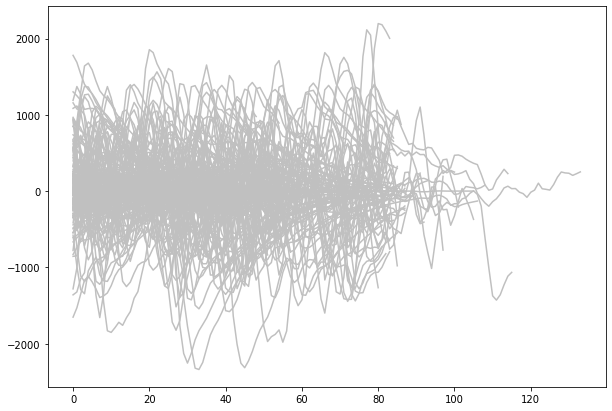

In [74]:
import matplotlib.pyplot as plt

# signals[0]
P = result[0]['ECG_P_Peaks']
T = result[0]['ECG_T_Peaks']

s = signals[2].reset_index(drop=True).to_numpy()
print(s.shape)
fig = plt.figure(figsize=(10,7))

for p,t in zip(P,T):
    plt.plot(s[p:t],color='silver')

In [76]:
signals[2].shape

(29696,)

In [71]:
print(signals[0].shape)
print(signals[1].shape)
print(signals[2].shape)


(28416,)
(26112,)
(29696,)


In [72]:
28416+26112+29696

84224

In [44]:
edfs[1]['data'].to_data_frame()['ECG']

0          572.991453
1            0.195360
2            1.367521
3            1.367521
4           -0.586081
              ...    
3692283    183.833944
3692284    167.423687
3692285    172.503053
3692286    186.178266
3692287    178.363858
Name: ECG, Length: 3692288, dtype: float64